# Single Image Denoising

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
import os


from helper_images import image_to_patches, patches_to_image_with_positions, preprocess_images, get_patches_from_images, flatten_patches


import sys
sys.path.insert(0, '/data/shiyu/projects/MT/MT_ICML_OOP')
from models.manifold_traversal import ManifoldTraversal


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  
})

# get data

In [6]:
image_path = '/data/shiyu/projects/MT/MT_ICML_OOP/data/image_data/single_image_data/0801.png'



# Load the image
img = Image.open(image_path)
img_array = np.array(img)
print(f'image size is {img_array.shape}')


sigma = 0.1 #noise level
images = [img_array] #single image denoising



is_single_image = True
if is_single_image:
    idx_test  = 0


orig_img_scaled, img_scaled, noisy_images, clean_images = preprocess_images(images=images, start_idx=0, num_imgs=1, sigma=sigma)
clean_patches, noisy_patches, clean_positions, noisy_positions, N_patches_per_img = get_patches_from_images(clean_images=clean_images, noisy_images=noisy_images, patch_size=8, stride=4)
clean_patches_flattened, noisy_patches_flattened = flatten_patches(clean_patches=clean_patches, noisy_patches=noisy_patches)



#shuffle the data
permutation = np.random.permutation(len(noisy_patches_flattened))
shuffled_clean_patches = clean_patches_flattened[permutation, :]
shuffled_noisy_patches = noisy_patches_flattened[permutation, :]



X_natural_train = shuffled_clean_patches.T
X_train = shuffled_noisy_patches.T
print(f'X_train shape is {X_train.shape}')

N_train = X_train.shape[1]
print(f'N_train = {N_train}')



#dimensions
D = clean_patches[0].shape[1] * clean_patches[0].shape[2] * clean_patches[0].shape[3]
d = 4

print(f'D = {D}, d = {d}')

image size is (1356, 2040, 3)
Total number of original images: len(img_scaled_orig) = 1
Total number of RGB images: len(img_scaled) for training = 1
Number of clean images: len(clean_images) = 1
Number of noisy images: len(noisy_images) = 1
Number of total patches in noisy images: 172042
X_train shape is (192, 172042)
N_train = 172042
D = 192, d = 4


# train MT

In [8]:
mt = ManifoldTraversal(
    intrinsic_dim=d,
    ambient_dim=D,
    sigma=sigma,
    R_denoising=np.sqrt(2.06 * sigma**2 * D),
    R_1st_order_nbhd=np.sqrt(2.39 * sigma**2 * D),
    R_is_const=True,
    d_parallel=np.sqrt(20 * sigma**2 * d),
    prod_coeff=1.2,
    exp_coeff=0.5
)

In [9]:
results = mt.fit(X_train, X_natural_train, batch_size=4000, verbose=True)

Training manifold traversal on 172042 samples...
4000 samples processed (batch time: 3.69s)
8000 samples processed (batch time: 6.32s)
12000 samples processed (batch time: 8.15s)
16000 samples processed (batch time: 8.92s)
20000 samples processed (batch time: 10.14s)
24000 samples processed (batch time: 10.03s)
28000 samples processed (batch time: 12.30s)
32000 samples processed (batch time: 13.02s)
36000 samples processed (batch time: 14.04s)
40000 samples processed (batch time: 15.32s)
44000 samples processed (batch time: 16.81s)
48000 samples processed (batch time: 17.37s)
52000 samples processed (batch time: 17.67s)
56000 samples processed (batch time: 17.89s)
60000 samples processed (batch time: 20.53s)
64000 samples processed (batch time: 19.21s)
68000 samples processed (batch time: 20.62s)
72000 samples processed (batch time: 21.87s)
76000 samples processed (batch time: 22.46s)
80000 samples processed (batch time: 22.73s)
84000 samples processed (batch time: 22.07s)
88000 sample

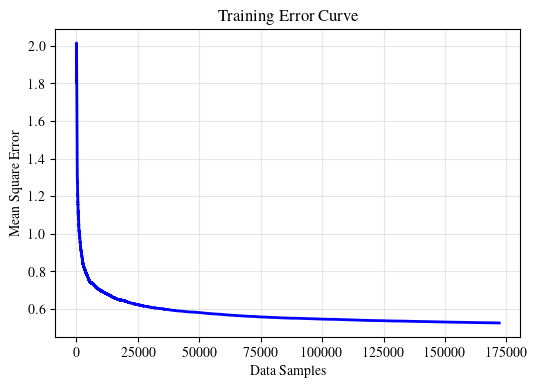

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(results.mean_MT_error, 'b-', linewidth=2)
plt.xlabel('Number of Samples Processed')
plt.ylabel('Mean Square Error')
plt.title('Training Error Curve')
plt.grid(True, alpha=0.3)

save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/results_image/single_image_training_error_curve.pdf'

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Denoising

In [18]:
#for single image denoising, test data is non-shuffled training data itself


denoised_patches_flattened = np.zeros(noisy_patches_flattened.shape)

for n in range(N_train):
    x = noisy_patches_flattened[n,:]
    x_mt_hat = mt.denoise(x)
    denoised_patches_flattened[n,:] = x_mt_hat

denoised_patches = denoised_patches_flattened.reshape(-1, 8, 8, 3)

# plot

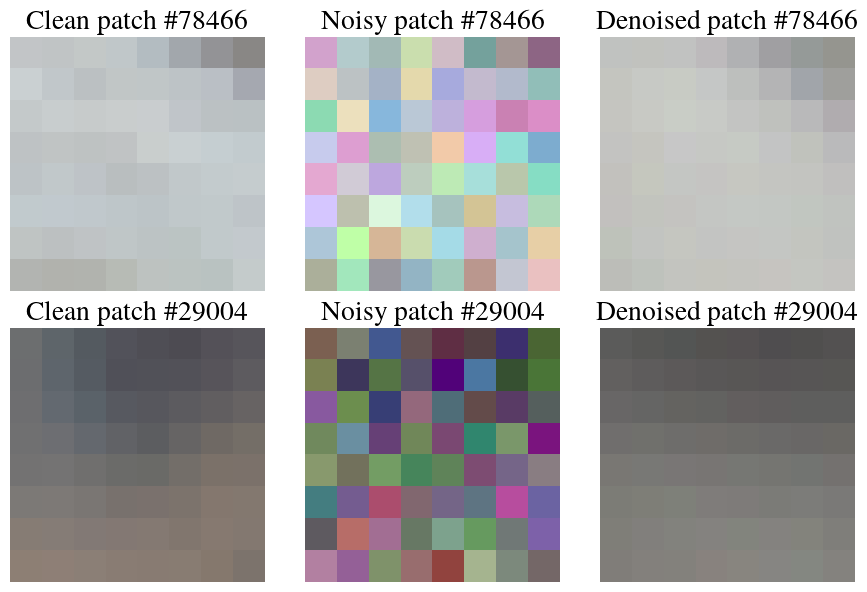

In [24]:
#plot patches

idx1 = np.random.randint(0, N_train)
idx2 = np.random.randint(0, N_train)




plt.figure(figsize=(9,6))

plt.subplot(231)
plt.imshow(np.clip(clean_patches[idx_test][idx1],0.0,1.0))
plt.title(r'Clean patch $\#%d$' % idx1, fontsize=20)
plt.axis('off')

plt.subplot(232)
plt.imshow(np.clip(noisy_patches[idx_test][idx1],0.0,1.0))
plt.title(r'Noisy patch $\#%d$' % idx1, fontsize=20)
plt.axis('off')

plt.subplot(233)
plt.imshow(np.clip(denoised_patches[idx1],0.0,1.0))
plt.title(r'Denoised patch $\#%d$' % idx1, fontsize=20)
plt.axis('off')

plt.subplot(234)
plt.imshow(np.clip(clean_patches[idx_test][idx2],0.0,1.0))
plt.title(r'Clean patch $\#%d$' % idx2, fontsize=20)
plt.axis('off')

plt.subplot(235)
plt.imshow(np.clip(noisy_patches[idx_test][idx2],0.0,1.0))
plt.title(r'Noisy patch $\#%d$' % idx2, fontsize=20)
plt.axis('off')

plt.subplot(236)
plt.imshow(np.clip(denoised_patches[idx2],0.0,1.0))
plt.title(r'Denoised patch $\#%d$' % idx2, fontsize=20)
plt.axis('off')
plt.tight_layout()

save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/results_image/single_image_patches.pdf'

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches="tight")

noisy-orig-sqdist - denoised-orig-sqdist is 67351.67547300711
clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is 63606.269064498745
--------------------------------------------------------------------------------------------------


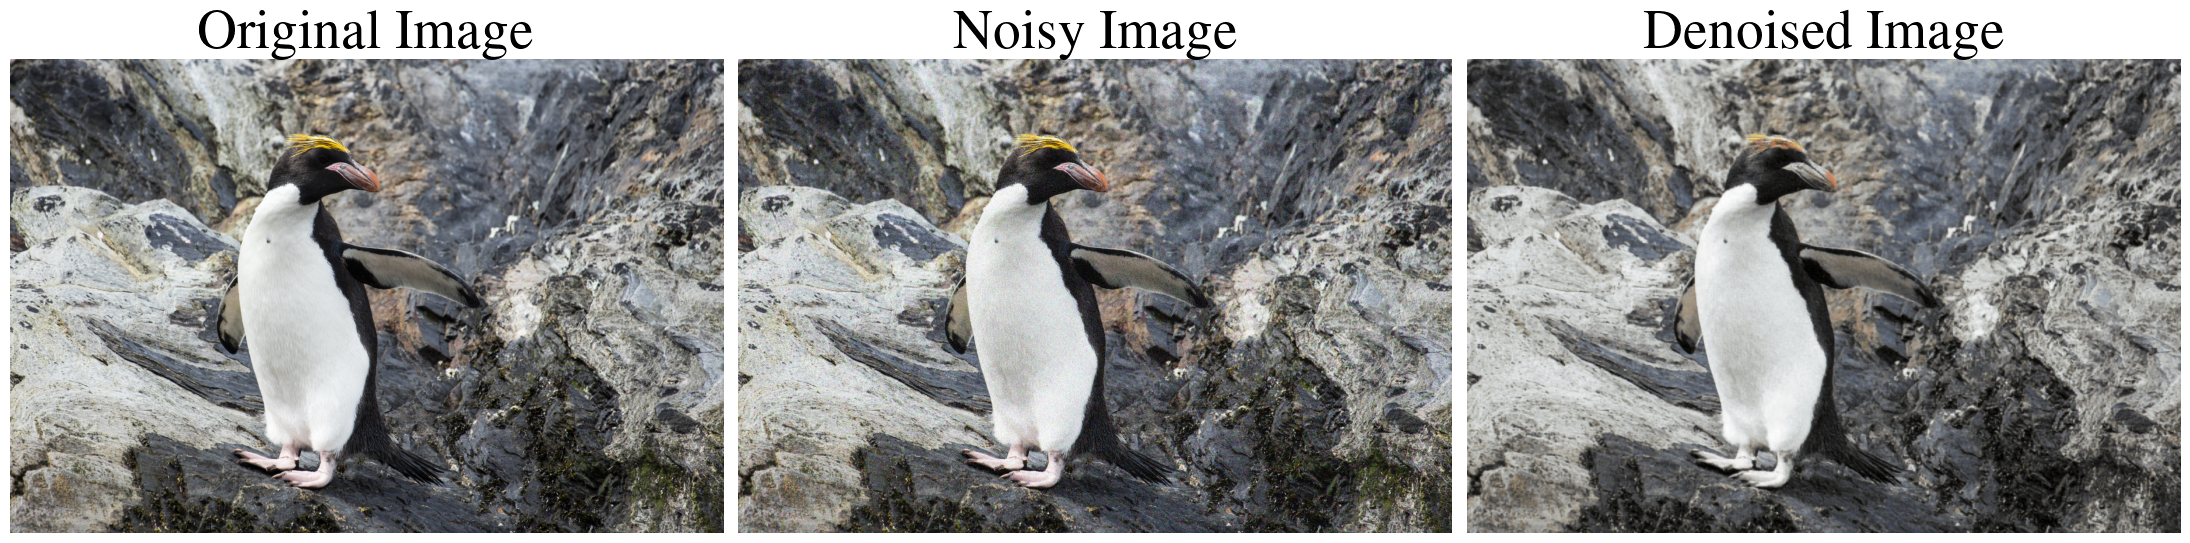

In [27]:

img_scaled_clip = np.clip(img_scaled, 0.0, 1.0)
noisy_img_clip = np.clip(noisy_images, 0.0, 1.0)




denoised_image = patches_to_image_with_positions(denoised_patches, noisy_positions[idx_test], img_scaled[idx_test].shape[0], img_scaled[idx_test].shape[1])

denoised_image_clip = np.clip(denoised_image, 0.0, 1.0) #denoised single image

noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled[idx_test] - noisy_images[idx_test])**2) - np.sum((img_scaled[idx_test] - denoised_image)**2)
clip_noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled_clip[idx_test] - noisy_img_clip[idx_test])**2) - np.sum((img_scaled_clip[idx_test] - denoised_image_clip)**2)



print(f'noisy-orig-sqdist - denoised-orig-sqdist is {noisy_orig_sqdist_denoised_orig_sqdist}')
print(f'clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is {clip_noisy_orig_sqdist_denoised_orig_sqdist}')
print('--------------------------------------------------------------------------------------------------')

plt.figure(figsize=(22, 9))

plt.subplot(1, 3, 1)
plt.imshow(img_scaled_clip[idx_test])
plt.title(r'Original Image', fontsize=40)  # Bold text in LaTeX
# plt.savefig(f"single_image_orig_img_{net_idx}.pdf", bbox_inches="tight")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img_clip[idx_test])
plt.title(r'Noisy Image', fontsize=40)  # Bold text in LaTeX
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(denoised_image_clip)
plt.title(r'Denoised Image', fontsize=40)  # Bold text in LaTeX
plt.axis('off')
plt.tight_layout()



save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/results_image/single_image_denoising.pdf'

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches="tight")